## ANSWERS FOR QUESTIONS
`ANSWERS:`

### What do you think might be a shortcoming of the previous representation of utterance features? 
- If the records contain new words, then size of the matrix would continue to increase which is not efficient.
- There are many zeros in the vector thus resulting in a very sparse matrix which needs to be avoided.
- There is not information on grammer from the sentences or ordering of the words in the text hence the text cannot be reconstructed without loosing information.


### SGDClassifier Results.
- On validation, `JOY` untterance was the one with lowest prediction score althought it was just less 1% from others.
- The average accuracy for the model was 60% which means, for every text that is predicted, it is 60% accurate that it is in the correct label of utterance.
- Most of the `JOYFUL` utterance were being predicted as `JEALOUS` with 70 values done this.
- Below are results achieved by SGDclassifier model

```
    Accuracy :   59.65250965250966%
    F1 Score :   59.553625217041805%
    Recall Score :   59.65250965250966%
    Precision Score :   59.741581794172774%
```


### MLP with Word2Vec results.
- Below is the results achieved by MLP model.
- gensim module was used to create word2vec model which was used in representation of text with similarities.
- The model did not have good accuracy,

```
        Accuracy :   46.46074646074646%
        F1 Score :   46.445182667051874%
        Recall Score :   46.46074646074646%
        Precision Score :   46.64679340139845%
```


### Explain how you use the BERT output. Specifically, which token(s) output you use?

- Bert is trained using Masked Language Model (MLM) and Next Sentence Prediction task (NSP).
- It recieves input as embedding i.e attention masks and sentences input ids.
- In each word, the first token is a special token called CLS and sentences are separed by also a special token called SEP
- The model's output are embedding for the hidden state. These output are the one to be feeded to layer that can be used for classification.
- In our task, we were only interested on these output (Hidden State) which are associated with initial token CLS since it captures the meaning of the entire senteses more than other hence these hidden state can be used for classification with other models as input.
- After training MLP model with features extracted using BERT model and tokenizers, the results had improved a bit as follows;
   ```
        Accuracy :   60.5%
        F1 Score :   60.24614807085745%
        Recall Score :   60.5%
        Precision Score :   60.650467636088266%
   ```

In [1]:
# Importing the required packages

import os
import re

import pandas as pd
import numpy as np

import gensim
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords 
import nltk
# nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


from itertools import compress
import collections


import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
# first step is to preprocess the data
os.listdir("../nlpdata/")


['valid.csv', 'train.csv', 'test.csv']

In [3]:
# Importing the datasets

train = pd.read_csv("./nlpdata/train.csv", usecols=["utterance", 'context'])
test = pd.read_csv("./nlpdata/test.csv", usecols=["utterance", 'context'])
valid = pd.read_csv("./nlpdata/valid.csv", usecols=["utterance",'context'])

In [4]:
# check the shape
train.shape, test.shape, valid.shape

((76673, 2), (10943, 2), (12030, 2))

In [5]:
train.duplicated().sum()

510

In [6]:
test.duplicated().sum()

13

In [7]:
valid.duplicated().sum()

16

In [8]:
train.head()

,context,utterance
0,sentimental,I remember going to see the fireworks with my ...
1,sentimental,Was this a friend you were in love with_comma_...
2,sentimental,This was a best friend. I miss her.
3,sentimental,Where has she gone?
4,sentimental,We no longer talk.


### Filter Only the required categories.
- series.isin(list_ method is going to be used to filter out the rows that are required.
- After filtering, the record are resampled in order to be shuffled and the index is also reset.


In [9]:

# select "utterance" and "context" as your X and y
# only select {'sad', 'jealous', 'joyful', 'terrified'} categories
#

# use isin  method to filter out the required records
train = train[train['context'].isin(['sad', 'jealous', 'joyful', 'terrified'])].sample(frac=1).reset_index(drop=True)
test = test[test['context'].isin(['sad', 'jealous', 'joyful', 'terrified'])].sample(frac=1).reset_index(drop=True)
valid = valid[valid['context'].isin(['sad', 'jealous', 'joyful', 'terrified'])].sample(frac=1).reset_index(drop=True)

In [10]:
# recheck the shape
train.shape, test.shape, valid.shape

((9797, 2), (1377, 2), (1554, 2))

### Columns Renaming.
- The columns are renamed for easier accessibility i,e utterance is renamed to text while context to label

In [11]:
# rename the columns i.e label from context and text from utterance

train = train.rename({"context":"label", "utterance":"text"}, axis=1)
test = test.rename({"context":"label", "utterance":"text"}, axis=1)
valid = valid.rename({"context":"label", "utterance":"text"}, axis=1)

### Check Distribution of the Labels in each Data Group.


In [12]:
# check distribution of labels
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
train.label.value_counts(normalize=True)

sad          0.268858
terrified    0.253955
joyful       0.239461
jealous      0.237726
Name: label, dtype: float64

<AxesSubplot:xlabel='label', ylabel='count'>

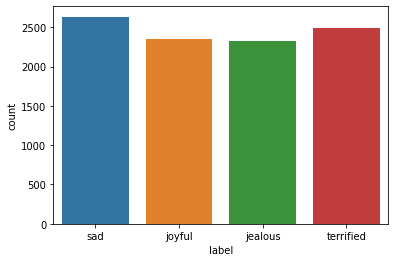

In [14]:
sns.countplot(train['label'])

In [15]:
test.label.value_counts(normalize=True)

sad          0.271605
joyful       0.257807
jealous      0.254176
terrified    0.216412
Name: label, dtype: float64

<AxesSubplot:xlabel='label', ylabel='count'>

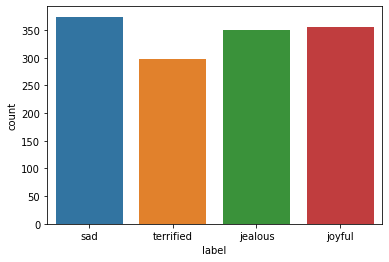

In [16]:
sns.countplot(test['label'])

In [17]:
valid.label.value_counts(normalize=True)

sad          0.281853
jealous      0.248391
joyful       0.237452
terrified    0.232304
Name: label, dtype: float64

<AxesSubplot:xlabel='label', ylabel='count'>

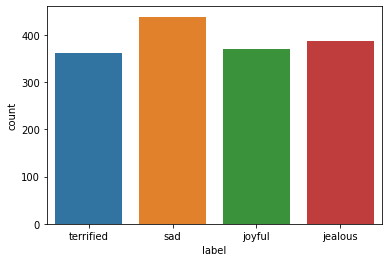

In [18]:
sns.countplot(valid['label'])

- The distibution of labels in all data set is almost similar. There is not that much imbalance in the dataset

In [19]:
# average number of words per record
train['text'].str.split(" ").apply(len).mean(), test['text'].str.split(" ").apply(len).mean(), valid['text'].str.split(" ").apply(len).mean()

(18.576400939062978, 16.267247639796658, 14.393822393822393)

### Encode the Labels.
- Models can't understand string labels, these labels are going to be assigned a code each. Label Encoder function will be used to automatically encode the string labels to numerical.

In [20]:
# get therse labels into a numerical format
from sklearn.preprocessing import LabelEncoder

lbl_enc = LabelEncoder()

lbl_enc.fit(train['label'])

LabelEncoder()

In [21]:
Ytrain= lbl_enc.transform(train['label'])
Ytest= lbl_enc.transform(test['label'])
Yvalid= lbl_enc.transform(valid['label'])

#### 2. sparse bag-of-words (BOW) representation.

- The CountVectorizer function will be used and a attribute passed to it to return binary values instead of counts

- In this place, the text will first be cleaned by removing punctuations or special characters.
- The function below does the work of removing special characters

In [22]:
# this function will be used to clean the text column above
#it also clean by removing some unwanted characters.
def text_processing(text):
    """
    It also removes punctuations
    and lastly it lemmatixe the word into its root form
    """
    
    #remove new lines escape characters
    text = re.sub(r"\n", "", text)
    # convert to lowercase
    text = text.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    # tokenize the text into words
    words = text.split()
    # return a new sentense with the applied functions
    return " ".join(words)

In [23]:
# run the function to process all text for train, text and valid dataset
Xtrain =train['text'].apply(text_processing)
Xtest =test['text'].apply(text_processing)
Xvalid =valid['text'].apply(text_processing)

# precheck sample cleaned daata
Xtrain

0       the summer has been rough though they fight a lot
1                    my god i would be too pop the bubbly
2          how many counties are you planning on vistiing
3       an infiniti my old volvo is the worst on the b...
4             i got robbedcomma while i was alone at home
                              ...                        
9792                    that is very smart to think about
9793     i really like summer time and going to the beach
9794    do you have fond memories of school or were yo...
9795                              does ghost really exist
9796    it wascomma actually im from louisiana and was...
Name: text, Length: 9797, dtype: object

In [24]:
# create a Sparse BOW vectorizer object
count_vectorizer = CountVectorizer(binary=True)

In [25]:
# fit the vectorizer with training data
count_vectorizer.fit(Xtrain)

CountVectorizer(binary=True)

In [26]:
# transform all training, validation and testing data using the vectorizer and convert back to an array
Xtrain = count_vectorizer.transform(Xtrain).toarray()
Xtest = count_vectorizer.transform(Xtest).toarray()
Xvalid = count_vectorizer.transform(Xvalid).toarray()

In [27]:
# check sample
Xtest

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
# check the shape
Xtrain.shape, Xtest.shape, Xvalid.shape

((9797, 11655), (1377, 11655), (1554, 11655))

In [29]:
del Xtrain, Xtest, Xvalid

### What do you think might be a shortcoming of the previous representation of utterance features? 
`ANSWERS`
```
- If the records contain new words, then size of the matrix would continue to increase which is not efficient.
- There are many zeros in the vector thus resulting in a very sparse matrix which needs to be avoided.
- There is not information on grammer from the sentences or ordering of the words in the text hence the text cannot be reconstructed without loosing information.
```


- You may have guessed there are many words which are not necessarily adding much value to the classifier. For instance, words like ‘the’, ‘is’, ‘and’ are not words that help us humans identify whether an utterance belongs to a specific sentiment class. As you would remember, these words are referred to as ‘stop words’ in the NLP domain.

- In this step, you will remove such stop words from the utterance and build the BOW features again so that your BOW representation is free of words that do not add much value to the classifier.

In [30]:
# Getting the list of stopwords and appending additional words to it
stopwords_list = list(set(stopwords.words('english')))

- The function below removes stopwords from the text, it is an extension of previous function.

In [31]:
# this function will be used to clean the text column above
# it get only words that are not stopwords and are of length over 3
#it also clean by removing some unwanted characters.
def text_processing_stopwords(text):
    """
    This function removes any stopwords in the text
    It also removes punctuations
    and lastly it lemmatixe the word into its root form
    """
    
    #remove new lines escape characters
    text = re.sub(r"\n", "", text)
    # convert to lowercase
    text = text.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]\s", "", text)
    
    # tokenize the text into words
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords_list]
    # return a new sentense with the applied functions
    return " ".join(words)

In [32]:
# apply the function to all dataset.
Xtrain_stop = train['text'].apply(text_processing_stopwords)
Xtest_stop = test['text'].apply(text_processing_stopwords)
Xvalid_stop = valid['text'].apply(text_processing_stopwords)

In [33]:
# check a sample.
Xvalid_stop

0       got arrested younger_commaand scared back poli...
1                                seriouswhy scared wreck?
2       yes_commai live orlando lucky central_commabut...
3             long time_commabut eventually got bit older
4                                    know feellife short.
                              ...                        
1549                rabbit died last year_commai miss day
1550            oh reallyi checking outi would love some.
1551         envy everyone outside right enjoying weather
1552    that's greati hope domaybe time get $40but gam...
1553    think positives new car doesnt mean life great...
Name: text, Length: 1554, dtype: object

In [34]:
# create a binary BOW vectorizer for the text data
count_vectorizer_stop = CountVectorizer(binary=False)

In [35]:
# train the vectorizer..
count_vectorizer_stop.fit(Xtrain_stop)

CountVectorizer()

In [36]:
# transform all data with the trained vectorizer that had its stopwords removed.
Xtrain_stop = count_vectorizer_stop.transform(Xtrain_stop).toarray()
Xtest_stop = count_vectorizer_stop.transform(Xtest_stop).toarray()
Xvalid_stop = count_vectorizer_stop.transform(Xvalid_stop).toarray()

In [37]:
# check shape..
Xtrain_stop.shape, Xtest_stop.shape, Xvalid_stop.shape

((9797, 14092), (1377, 14092), (1554, 14092))

#### Normalization: 
- Another problem with the current representation is that we weigh each non-stop-word term the same. 
- A proven way to normalize is Term Frequency - Inverse Document Frequency (TF-IDF). This should normalize frequencies in a weighted fashion to a value between 0 and 1.

- Below is the vectorization with TFIDF vectorizer..


In [38]:
# create tfidf object to vectorize the text
train_tfidf_transformer = TfidfTransformer()
# train the tfidf object using the processed text data
train_tfidf_transformer.fit(Xtrain_stop)


TfidfTransformer()

In [39]:
# transform all data using the trained tfidf vectorizer
Xtrain_tfidf = train_tfidf_transformer.transform(Xtrain_stop)
Xtest_tfidf = train_tfidf_transformer.transform(Xtest_stop)
Xvalid_tfidf = train_tfidf_transformer.transform(Xvalid_stop)

In [40]:
# check the shape
Xtrain_tfidf.shape, Xtest_tfidf.shape, Xvalid_tfidf.shape

((9797, 14092), (1377, 14092), (1554, 14092))

In [41]:
# check max and min value from the returned array
Xtrain_tfidf.toarray().min(), Xtrain_tfidf.toarray().max()

(0.0, 1.0)

#### Build a SGD classifier for the utterance sentiment classification and perform error analysis on the train data. 


In [42]:
sdg_clf = SGDClassifier(alpha=0.0001, average=True, max_iter=200, penalty='l2', loss='hinge', early_stopping=True,random_state=2022,tol=0.0001,
                        n_iter_no_change=4, epsilon=0.3, class_weight='balanced', validation_fraction=0.15)
# train
sdg_clf.fit(Xtrain_tfidf, Ytrain)

# get testiing accuracy
sdg_clf.score(Xtest_tfidf, Ytest)

0.5809731299927379

In [43]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [44]:
# function for model evaluation
def get_evaluations(model, x_test , y_test, model_name, clasical_model=True):
    print(f"\t\t********** {model_name}  Evaluation STATS **********\n")
    #get predicition from the trained model
    if clasical_model:
        model_preds = model.predict(x_test)
    else:
        model_preds = model.predict(x_test).argmax(axis=1)
        y_test = y_test.argmax(axis=1)
    
    #print these metrics.
    print(f"Accuracy :   {accuracy_score(y_test , model_preds)*100}%")
    print(f"F1 Score :   {f1_score(y_test , model_preds, average='weighted')*100}%")
    print(f"Recall Score :   {recall_score(y_test , model_preds, average='weighted')*100}%")
    print(f"Precision Score :   {precision_score(y_test , model_preds, average='weighted')*100}%\n")
    print("\tClasssification Report")
    print(classification_report(y_test, model_preds))
    #plot confusion plot
    c_matrix = confusion_matrix(lbl_enc.inverse_transform(y_test), lbl_enc.inverse_transform(model_preds))
    # plot cmatrix
    plt.figure(figsize=(8,8))
    sns.heatmap(c_matrix , annot= True ,fmt="" ,  annot_kws={"size": 10})
    plt.xlabel("Actual Label", fontsize=17, c='b')
    plt.ylabel("Predicted Label", fontsize=17, c='b')
    plt.title(f"Confusion Matrix Plot for {model_name} classifier", fontsize=16, c='b')

		********** SDG regression  Evaluation STATS **********

Accuracy :   59.65250965250966%
F1 Score :   59.553625217041805%
Recall Score :   59.65250965250966%
Precision Score :   59.741581794172774%

	Classsification Report
              precision    recall  f1-score   support

           0       0.59      0.56      0.58       386
           1       0.54      0.59      0.56       369
           2       0.62      0.55      0.58       438
           3       0.63      0.70      0.66       361

    accuracy                           0.60      1554
   macro avg       0.60      0.60      0.60      1554
weighted avg       0.60      0.60      0.60      1554



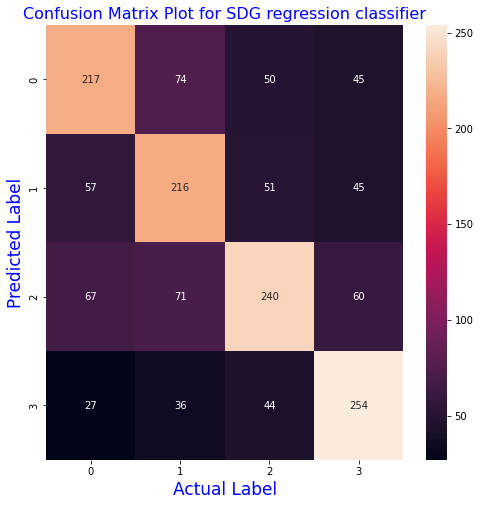

In [45]:
# get the SDG  evaluation
get_evaluations(sdg_clf, Xvalid_tfidf , Yvalid, "SDG regression")

### Observation
- On validation, `JOY` untterance was the one with lowest prediction score althought it was just less 1% from others.
- The average accuracy for the model was 60% which means, for every text that is predicted, it is 60% accurate that it is in the correct label of utterance.
- Most of the `JOYFUL` utterance were being predicted as `JEALOUS` with 70 values done this.

In [46]:
lbl_enc.classes_

array(['jealous', 'joyful', 'sad', 'terrified'], dtype=object)

In [47]:
del Xtrain_stop, Xtest_stop, Xvalid_stop

### Build a classifier using pre-trained word embeddings like word2vec or gloVe or as the feature and an MLP classifier. Report the confusion matrix, F1 score and test accuracy.

In [48]:
# use gensim to get w2vec model
import gensim

In [49]:
# using training data, train a word2vec model
w2v_model = gensim.models.Word2Vec(train['text'].apply(lambda x: gensim.utils.simple_preprocess(x)),
                                   vector_size=100,
                                   window=5,
                                   min_count=3)

In [50]:
# number of words we have as index in the word2vec model
len(w2v_model.wv.index_to_key)

3149

In [51]:
# Find the most similar words to "hello" based on word vectors from our trained model
w2v_model.wv.most_similar('hello')

[('unfortunately', 0.962105393409729),
 ('cake', 0.961903989315033),
 ('bummed', 0.9616461396217346),
 ('cancer', 0.9616392850875854),
 ('binders', 0.9608043432235718),
 ('once', 0.9605233669281006),
 ('red', 0.9600427746772766),
 ('season', 0.9599646329879761),
 ('minutes', 0.9597904086112976),
 ('beautiful', 0.9595981240272522)]

In [52]:
# Generate aggregated sentence vectors based on the word vectors for each word in the sentence
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in train['text'].apply(lambda x: gensim.utils.simple_preprocess(x))])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in test['text'].apply(lambda x: gensim.utils.simple_preprocess(x))])
X_val_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in valid['text'].apply(lambda x: gensim.utils.simple_preprocess(x))])

In [53]:
X_train_vect.shape, X_test_vect.shape, X_val_vect.shape

((9797,), (1377,), (1554,))

In [54]:
# padd the vectors to be of the same length (100) and find vectors average
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))
X_val_vect_avg = []
for v in X_val_vect:
    if v.size:
        X_val_vect_avg.append(v.mean(axis=0))
    else:
        X_val_vect_avg.append(np.zeros(100, dtype=float))

### Training the MLP Classifier using Word2Vec Features

In [55]:
len(X_train_vect_avg), len(X_test_vect_avg), len(X_val_vect_avg)

(9797, 1377, 1554)

In [56]:
X_test_vect_avg[0].shape

(100,)

In [57]:
np.array(X_test_vect_avg).reshape(-1, 100).shape

(1377, 100)

In [58]:
X_train_vect_avg = np.array(X_train_vect_avg).reshape(-1, 100)
X_test_vect_avg = np.array(X_test_vect_avg).reshape(-1, 100)
X_val_vect_avg = np.array(X_val_vect_avg).reshape(-1, 100)

In [59]:
#Initializing the MLPClassifier
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(200,10), 
    max_iter=300,
    activation = 'relu',
    solver='adam',
    random_state=0)

In [60]:
# train the mlp classifier
mlp_clf.fit(X_train_vect_avg, Ytrain)

MLPClassifier(hidden_layer_sizes=(200, 10), max_iter=300, random_state=0)

In [61]:
# get the score on test data
mlp_clf.score(X_test_vect_avg, Ytest)

0.4713144517066086

		********** MLP with Word2Vec Classifier  Evaluation STATS **********

Accuracy :   46.46074646074646%
F1 Score :   46.445182667051874%
Recall Score :   46.46074646074646%
Precision Score :   46.64679340139845%

	Classsification Report
              precision    recall  f1-score   support

           0       0.42      0.47      0.45       386
           1       0.48      0.41      0.44       369
           2       0.47      0.49      0.48       438
           3       0.49      0.49      0.49       361

    accuracy                           0.46      1554
   macro avg       0.47      0.46      0.46      1554
weighted avg       0.47      0.46      0.46      1554



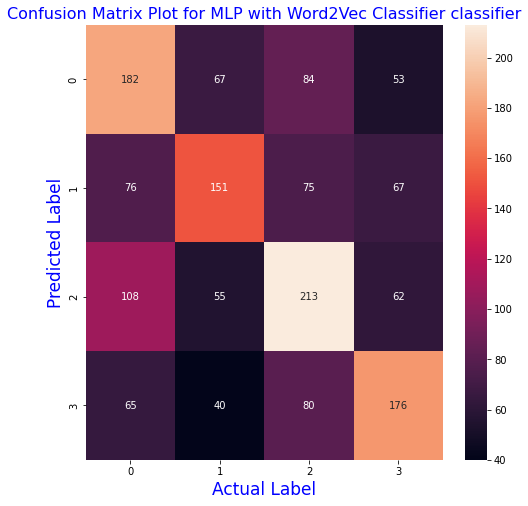

In [62]:
# score for evaluation data
get_evaluations(mlp_clf, X_val_vect_avg , Yvalid, "MLP with Word2Vec Classifier")

#### Build a classifier based on BERT and MLP. 
- Specifically, which token(s) output you use? 

In [63]:
import torch
from transformers import AutoTokenizer, AutoModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [64]:
# original sentense
print(' Original: ', train['text'].iloc[0])

# tokenizer
print('Tokenized text: ', tokenizer.tokenize(train['text'].iloc[0]))

# ids for tokkne
print('Token Identifiers: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train['text'].iloc[0])))

 Original:  The summer has been rough though. They fight a lot
Tokenized text:  ['the', 'summer', 'has', 'been', 'rough', 'though', '.', 'they', 'fight', 'a', 'lot']
Token Identifiers:  [1996, 2621, 2038, 2042, 5931, 2295, 1012, 2027, 2954, 1037, 2843]


In [65]:
# tokenizer?

### GETTING ONLY A PORTION OF THE DATASET.
- Since using BERT is computation intensive, the model was crashing when we want to get features for all dataset.
- To overcome this, 5000 records are gotten for training, 1000 for testing and 800 for validation

In [66]:
train = train.sample(5000, random_state=2022).reset_index(drop=True)
test = test.sample(1000, random_state=2022).reset_index(drop=True)
valid = valid.sample(800, random_state=2022).reset_index(drop=True)

In [67]:
valid

,label,text
0,terrified,I agree. I bet the little kids have never seen...
1,terrified,did he end up biting you??
2,terrified,I was scared to fly for the first time
3,terrified,It sounded like a train going by the house fro...
4,terrified,I am a mother not a father silly. Yes I made ...
...,...,...
795,terrified,The other night_comma_ drunk bicyclists were f...
796,jealous,Interesting_comma_ those things are huge_comma...
797,terrified,The other day this creepy guy followed me arou...
798,joyful,It was just some stuff for a new job. Do you f...


In [68]:
# tokenize all the dataset
tokenized_train = tokenizer(train["text"].values.tolist(), padding = True, truncation = True, return_tensors="pt", max_length=50)
tokenized_test = tokenizer(test["text"].values.tolist() , padding = True, truncation = True,  return_tensors="pt", max_length=50)
tokenized_val = tokenizer(valid["text"].values.tolist() , padding = True, truncation = True,  return_tensors="pt", max_length=50)

In [69]:
# train['text'].apply(len).sort_values(ascending=False)

In [70]:
# del tokenized_test, tokenized_val

In [71]:
tokenized_train['input_ids'][1095]

tensor([ 101, 1045, 2572, 2469, 2017, 2024,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

In [72]:
# check keys
print(tokenized_train.keys())

dict_keys(['input_ids', 'attention_mask'])


In [73]:
#move the values to gpu for faster training
tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
tokenized_test = {k:torch.tensor(v).to(device) for k,v in tokenized_test.items()}
tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

In [74]:
torch.cuda.empty_cache()
import gc
# del w2v_model
# del X_test_vect, Xtest_stop, Xtrain_tfidf,
# del  X_test_vect_avg, X_val_vect_avg, X_train_vect_avg,X_val_vect, X_train_vect
gc.collect()

246

In [75]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  265843 KB |  265843 KB |  265843 KB |       0 B  |
|       from large pool |  264192 KB |  264192 KB |  264192 KB |       0 B  |
|       from small pool |    1651 KB |    1651 KB |    1651 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  265843 KB |  265843 KB |  265843 KB |       0 B  |
|       from large pool |  264192 KB |  264192 KB |  264192 KB |

In [76]:
# get the features from the model
with torch.no_grad():
    #dimension will be  [batch_size(nr_sentences), tokens, emb_dim]
    hidden_train = model(**tokenized_train)
    hidden_test = model(**tokenized_test)
    hidden_val = model(**tokenized_val)
    print("Done Training getting the features..")


Done Training getting the features..


In [77]:
# get the features extracted

#get only the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_test = hidden_test.last_hidden_state[:,0,:]
cls_val = hidden_val.last_hidden_state[:,0,:]

In [78]:
# check sample CLS

cls_val

tensor([[ 0.1987,  0.2273,  0.0128,  ...,  0.0953,  0.5151,  0.3996],
        [ 0.0433,  0.0151, -0.0713,  ..., -0.1160,  0.3578,  0.1802],
        [-0.0280, -0.0688, -0.1634,  ..., -0.0595,  0.2458,  0.3044],
        ...,
        [ 0.0432, -0.0604, -0.1613,  ...,  0.0307,  0.4360,  0.1981],
        [ 0.0914,  0.0067,  0.0041,  ..., -0.0701,  0.2584,  0.2643],
        [ 0.2176,  0.1288, -0.0632,  ...,  0.0400,  0.3324,  0.2181]],
       device='cuda:0')

In [79]:
# shape
cls_val.shape

torch.Size([800, 768])

In [80]:
#Initializing the MLPClassifier
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(200,10), 
    max_iter=300,
    activation = 'relu',
    solver='adam',
    random_state=0)

In [81]:
# train the model
mlp_clf.fit(cls_train.to("cpu"), lbl_enc.transform(train['label']))

MLPClassifier(hidden_layer_sizes=(200, 10), max_iter=300, random_state=0)

In [82]:
# get score on test data
mlp_clf.score(cls_test.to("cpu"), lbl_enc.transform(test['label']))

0.605

		********** MLP with Bert Features Test  Evaluation STATS **********

Accuracy :   60.5%
F1 Score :   60.24614807085745%
Recall Score :   60.5%
Precision Score :   60.650467636088266%

	Classsification Report
              precision    recall  f1-score   support

           0       0.62      0.48      0.54       244
           1       0.60      0.59      0.60       268
           2       0.57      0.65      0.61       275
           3       0.64      0.70      0.67       213

    accuracy                           0.60      1000
   macro avg       0.61      0.61      0.60      1000
weighted avg       0.61      0.60      0.60      1000



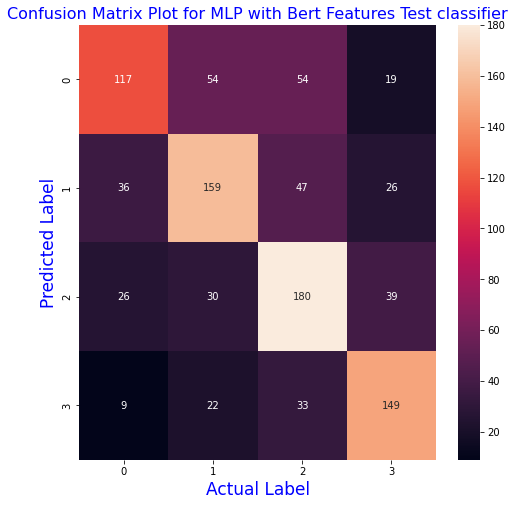

In [83]:
# score for evaluation data
get_evaluations(mlp_clf, cls_test.to("cpu") , lbl_enc.transform(test['label']), "MLP with Bert Features Test")

		********** MLP with Bert Features Valid  Evaluation STATS **********

Accuracy :   57.62500000000001%
F1 Score :   57.596723418469196%
Recall Score :   57.62500000000001%
Precision Score :   57.71637654154059%

	Classsification Report
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       205
           1       0.57      0.58      0.58       187
           2       0.51      0.55      0.53       222
           3       0.66      0.67      0.66       186

    accuracy                           0.58       800
   macro avg       0.58      0.58      0.58       800
weighted avg       0.58      0.58      0.58       800



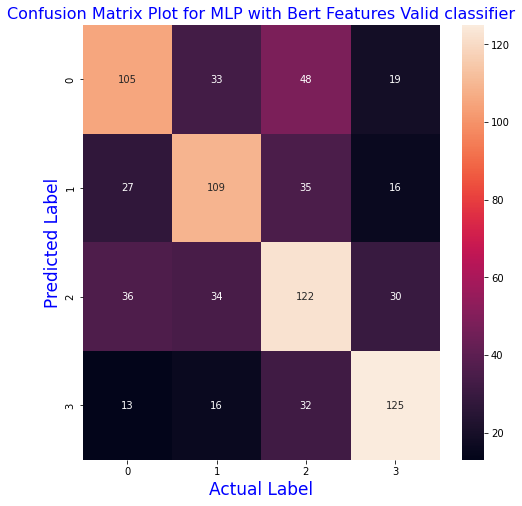

In [84]:
# score for evaluation data
get_evaluations(mlp_clf, cls_val.to("cpu") , lbl_enc.transform(valid['label']), "MLP with Bert Features Valid")

### Explain how you use the BERT output. Specifically, which token(s) output you use?

- Bert is trained using Masked Language Model (MLM) and Next Sentence Prediction task (NSP).
- It recieves input as embedding i.e attention masks and sentences input ids.
- In each word, the first token is a special token called CLS and sentences are separed by also a special token called SEP
- The model's output are embedding for the hidden state. These output are the one to be feeded to layer that can be used for classification.
- In our task, we were only interested on these output (Hidden State) which are associated with initial token CLS since it captures the meaning of the entire senteses more than other hence these hidden state can be used for classification with other models as input.